In [39]:
from __future__ import print_function

import numpy as np
#import reflexxes
import random
import pandas as pd
from numpy import genfromtxt

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from hmmlearn import hmm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances
import datetime

In [72]:
# load data
org_p = np.loadtxt('../Trajectory/data/original_position_list.csv', delimiter=' ')
org_v = np.loadtxt('../Trajectory/data/original_velocity_list.csv', delimiter=' ')
nos_p_001 = np.loadtxt('../Trajectory/data/position_noise_0.01.csv', delimiter=' ')
nos_p_01 = np.loadtxt('../Trajectory/data/position_noise_0.1.csv', delimiter=' ')
nos_p_1 = np.loadtxt('../Trajectory/data/position_noise_1.csv', delimiter=' ')

traj_lens = np.loadtxt('../Trajectory/data/traj_lens.csv', delimiter=' ')
traj_lens = traj_lens.astype(int)
      

[[10.0, 10.0, 10.0], [10.0, 10.0, 30.0], [10.0, 10.0, 50.0], [10.0, 10.0, 70.0], [10.0, 10.0, 90.0], [10.0, 30.0, 10.0], [10.0, 30.0, 30.0], [10.0, 30.0, 50.0], [10.0, 30.0, 70.0], [10.0, 30.0, 90.0], [10.0, 50.0, 10.0], [10.0, 50.0, 30.0], [10.0, 50.0, 50.0], [10.0, 50.0, 70.0], [10.0, 50.0, 90.0], [10.0, 70.0, 10.0], [10.0, 70.0, 30.0], [10.0, 70.0, 50.0], [10.0, 70.0, 70.0], [10.0, 70.0, 90.0], [10.0, 90.0, 10.0], [10.0, 90.0, 30.0], [10.0, 90.0, 50.0], [10.0, 90.0, 70.0], [10.0, 90.0, 90.0], [30.0, 10.0, 10.0], [30.0, 10.0, 30.0], [30.0, 10.0, 50.0], [30.0, 10.0, 70.0], [30.0, 10.0, 90.0], [30.0, 30.0, 10.0], [30.0, 30.0, 30.0], [30.0, 30.0, 50.0], [30.0, 30.0, 70.0], [30.0, 30.0, 90.0], [30.0, 50.0, 10.0], [30.0, 50.0, 30.0], [30.0, 50.0, 50.0], [30.0, 50.0, 70.0], [30.0, 50.0, 90.0], [30.0, 70.0, 10.0], [30.0, 70.0, 30.0], [30.0, 70.0, 50.0], [30.0, 70.0, 70.0], [30.0, 70.0, 90.0], [30.0, 90.0, 10.0], [30.0, 90.0, 30.0], [30.0, 90.0, 50.0], [30.0, 90.0, 70.0], [30.0, 90.0, 90.0],

In [16]:
# reframe dataset as per traj_lens
traj_lens_cumsum = traj_lens.cumsum()
traj_lens_cumsum = np.delete(traj_lens_cumsum, len(traj_lens_cumsum) - 1)

org_p_spl = np.split(org_p, traj_lens_cumsum, axis=0)
org_v_spl = np.split(org_v, traj_lens_cumsum, axis=0)
nos_p_001_spl = np.split(nos_p_001, traj_lens_cumsum, axis=0)
nos_p_01_spl = np.split(nos_p_01, traj_lens_cumsum, axis=0)
nos_p_1_spl = np.split(nos_p_1, traj_lens_cumsum, axis=0)

print(f'org_p.size: {len(org_p_spl)}')
print(f'org_v.size: {len(org_v_spl)}')
print(f'nos_p_001.size: {len(nos_p_001_spl)}')
print(f'nos_p_01.size: {len(nos_p_01_spl)}')
print(f'nos_p_1.size: {len(nos_p_1_spl)}')

org_p.size: 100
org_v.size: 100
nos_p_001.size: 100
nos_p_01.size: 100
nos_p_1.size: 100


In [74]:
# plot data function
def on_key_press(event):
    if event.key == 'escape':
        plt.close()
        
def original_plot(x, dd, dddx):
    t = np.linspace(0, len(x) * gen.cycle_time, len(x))
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.canvas.mpl_connect('key_press_event', on_key_press)
    ax1.plot(t, x)
    ax1.set_ylabel('position')
    ax1.legend('123', title='DOF #')
    ax2.plot(t, dx)
    ax2.set_ylabel('velocity')
    ax2.legend('123', title='DOF #')
    ax3.plot(t, ddx)
    ax3.set_ylabel('acceleration')
    ax3.legend('123', title='DOF #')
    ax3.set_xlabel('time')
    plt.show()
    
def plot_trajectory(x, title):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    ax.plot3D(xline, yline, zline, 'green')

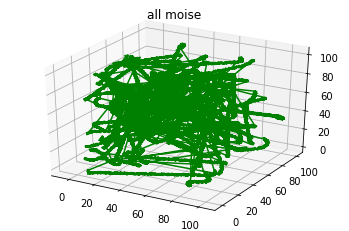

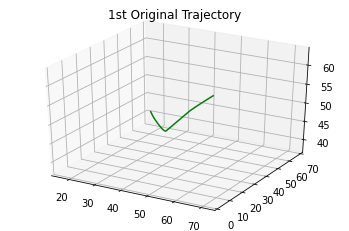

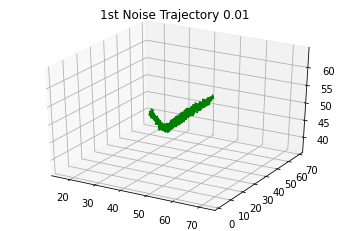

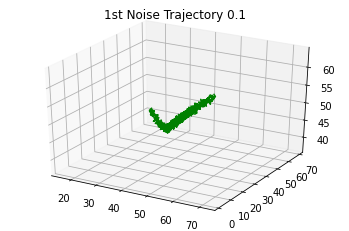

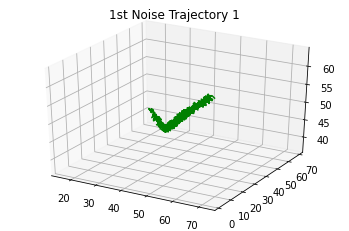

In [18]:
# plot 1st trajectory 
plot_trajectory(nos_p_1, 'all noise')
plot_trajectory(org_p_spl[0], '1st Original Trajectory')
plot_trajectory(nos_p_001_spl[0], '1st Noise Trajectory 0.01')
plot_trajectory(nos_p_01_spl[0], '1st Noise Trajectory 0.1')
plot_trajectory(nos_p_1_spl[0], '1st Noise Trajectory 1')

In [73]:
# try label no. = 10

init_mean = []
num = 5 # number of component in each diagonal

for i in range(num):
    for j in range(num):
        for k in range(num):
            init_mean.append([i * (100/num) + (50/num), j * (100/num) + (50/num), k * (100/num) + (50/num)])
#print(init_mean)   

a = datetime.datetime.now()
HMM_10 = hmm.GaussianHMM(n_components=125, covariance_type="spherical", init_params="sct", params="sct", n_iter=len(traj_lens), verbose=True)
HMM_10.means_ = init_mean
HMM_10.fit(org_p, traj_lens)
b = datetime.datetime.now()
print(b-a)

[[10.0, 10.0, 10.0], [10.0, 10.0, 30.0], [10.0, 10.0, 50.0], [10.0, 10.0, 70.0], [10.0, 10.0, 90.0], [10.0, 30.0, 10.0], [10.0, 30.0, 30.0], [10.0, 30.0, 50.0], [10.0, 30.0, 70.0], [10.0, 30.0, 90.0], [10.0, 50.0, 10.0], [10.0, 50.0, 30.0], [10.0, 50.0, 50.0], [10.0, 50.0, 70.0], [10.0, 50.0, 90.0], [10.0, 70.0, 10.0], [10.0, 70.0, 30.0], [10.0, 70.0, 50.0], [10.0, 70.0, 70.0], [10.0, 70.0, 90.0], [10.0, 90.0, 10.0], [10.0, 90.0, 30.0], [10.0, 90.0, 50.0], [10.0, 90.0, 70.0], [10.0, 90.0, 90.0], [30.0, 10.0, 10.0], [30.0, 10.0, 30.0], [30.0, 10.0, 50.0], [30.0, 10.0, 70.0], [30.0, 10.0, 90.0], [30.0, 30.0, 10.0], [30.0, 30.0, 30.0], [30.0, 30.0, 50.0], [30.0, 30.0, 70.0], [30.0, 30.0, 90.0], [30.0, 50.0, 10.0], [30.0, 50.0, 30.0], [30.0, 50.0, 50.0], [30.0, 50.0, 70.0], [30.0, 50.0, 90.0], [30.0, 70.0, 10.0], [30.0, 70.0, 30.0], [30.0, 70.0, 50.0], [30.0, 70.0, 70.0], [30.0, 70.0, 90.0], [30.0, 90.0, 10.0], [30.0, 90.0, 30.0], [30.0, 90.0, 50.0], [30.0, 90.0, 70.0], [30.0, 90.0, 90.0],

         1     -929436.3225             +nan
         2     -811602.7418     +117833.5807
         3     -737913.0352      +73689.7066
         4     -662957.1833      +74955.8519
         5     -632489.5403      +30467.6430
         6     -628819.3425       +3670.1978
         7     -628324.8250        +494.5175
         8     -628195.1181        +129.7069
         9     -628100.7291         +94.3890
        10     -628046.7426         +53.9865
        11     -628012.6418         +34.1008
        12     -627980.6238         +32.0181
        13     -627941.8800         +38.7437
        14     -627939.0591          +2.8210
        15     -627938.6346          +0.4244
        16     -627938.2607          +0.3739
        17     -627937.9603          +0.3004
        18     -627937.8000          +0.1603
        19     -627937.7159          +0.0841
        20     -627937.6582          +0.0576
        21     -627937.6142          +0.0440
        22     -627937.5819          +0.0323
        23

1:22:33.151093


        25     -627937.5372          +0.0088


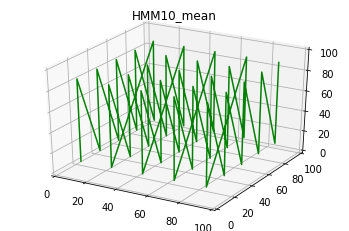

In [75]:
# plot means
plot_trajectory(HMM_10.means_, 'HMM10_mean')
#print(HMM_10.means_)

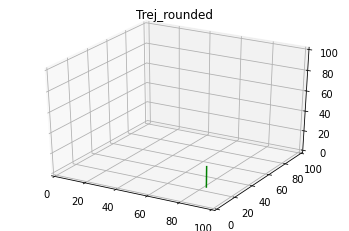

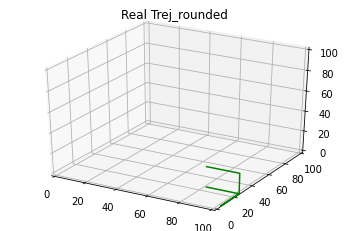

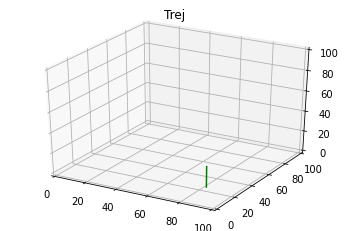

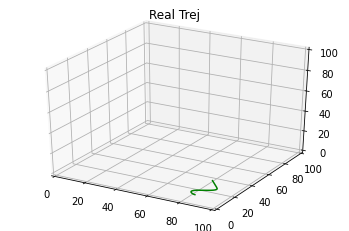

In [90]:
select_traj = 77
pred = HMM_10.predict(org_p_spl[select_traj])
orig_rd = np.ceil(org_p_spl[select_traj]/20)*20-10
trej_rd = []
trej = []

for point in pred:
    trej_rd.append(np.ceil(HMM_10.means_[point]/20)*20-10)
plot_trajectory(trej_rd, 'Trej_rounded')
plot_trajectory(orig_rd, 'Real Trej_rounded')

for point in pred:
    trej.append(HMM_10.means_[point])
plot_trajectory(trej, 'Trej')
plot_trajectory(org_p_spl[select_traj], 'Real Trej')

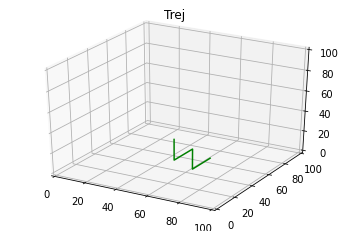

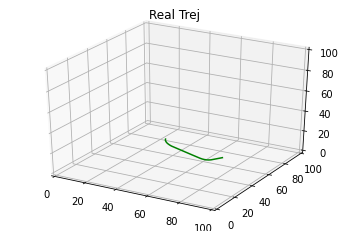

In [87]:
pred = HMM_10.predict(org_p_spl[select_traj])
trej = []
for point in pred:
    trej.append(HMM_10.means_[point])
plot_trajectory(trej, 'Trej')
plot_trajectory(org_p_spl[select_traj], 'Real Trej')

In [89]:
print(HMM_10.means_)

[[10. 10. 10.]
 [10. 10. 30.]
 [10. 10. 50.]
 [10. 10. 70.]
 [10. 10. 90.]
 [10. 30. 10.]
 [10. 30. 30.]
 [10. 30. 50.]
 [10. 30. 70.]
 [10. 30. 90.]
 [10. 50. 10.]
 [10. 50. 30.]
 [10. 50. 50.]
 [10. 50. 70.]
 [10. 50. 90.]
 [10. 70. 10.]
 [10. 70. 30.]
 [10. 70. 50.]
 [10. 70. 70.]
 [10. 70. 90.]
 [10. 90. 10.]
 [10. 90. 30.]
 [10. 90. 50.]
 [10. 90. 70.]
 [10. 90. 90.]
 [30. 10. 10.]
 [30. 10. 30.]
 [30. 10. 50.]
 [30. 10. 70.]
 [30. 10. 90.]
 [30. 30. 10.]
 [30. 30. 30.]
 [30. 30. 50.]
 [30. 30. 70.]
 [30. 30. 90.]
 [30. 50. 10.]
 [30. 50. 30.]
 [30. 50. 50.]
 [30. 50. 70.]
 [30. 50. 90.]
 [30. 70. 10.]
 [30. 70. 30.]
 [30. 70. 50.]
 [30. 70. 70.]
 [30. 70. 90.]
 [30. 90. 10.]
 [30. 90. 30.]
 [30. 90. 50.]
 [30. 90. 70.]
 [30. 90. 90.]
 [50. 10. 10.]
 [50. 10. 30.]
 [50. 10. 50.]
 [50. 10. 70.]
 [50. 10. 90.]
 [50. 30. 10.]
 [50. 30. 30.]
 [50. 30. 50.]
 [50. 30. 70.]
 [50. 30. 90.]
 [50. 50. 10.]
 [50. 50. 30.]
 [50. 50. 50.]
 [50. 50. 70.]
 [50. 50. 90.]
 [50. 70. 10.]
 [50. 70. 

In [46]:
pred

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [54]:
# try label no. = 10
a = datetime.datetime.now()
HMM_sph = hmm.GaussianHMM(n_components=30, covariance_type="spherical", n_iter=len(traj_lens), verbose=True)
HMM_sph.fit(org_p, traj_lens)
b = datetime.datetime.now()
print(b-a)

         1     -915537.2588             +nan
         2     -789906.2917     +125630.9671
         3     -722575.6612      +67330.6305
         4     -696579.6077      +25996.0535
         5     -692978.5188       +3601.0890
         6     -692486.1956        +492.3232
         7     -692288.3177        +197.8778
         8     -692212.6574         +75.6603
         9     -692177.3987         +35.2587
        10     -692151.9902         +25.4085
        11     -692137.0225         +14.9677
        12     -692124.9893         +12.0332
        13     -692111.9852         +13.0041
        14     -692101.5638         +10.4214
        15     -692095.8850          +5.6788
        16     -692091.4415          +4.4435
        17     -692085.7974          +5.6441
        18     -692082.0910          +3.7064
        19     -692079.8345          +2.2565
        20     -692078.1264          +1.7082
        21     -692076.8313          +1.2951
        22     -692075.6481          +1.1832
        23

0:13:39.086616


        71     -690444.3493          +0.0091


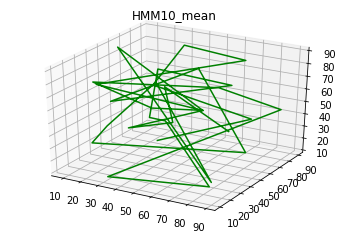

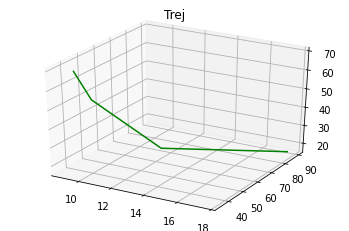

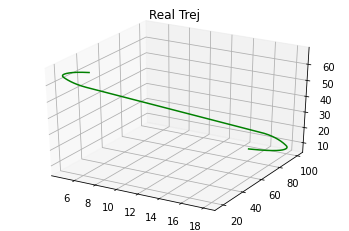

In [55]:
# plot means
plot_trajectory(HMM_sph.means_, 'HMM10_mean')

pred = HMM_sph.predict(org_p_spl[8])
trej = []
for point in pred:
    trej.append(HMM_sph.means_[point])
plot_trajectory(trej, 'Trej')
plot_trajectory(org_p_spl[8], 'Real Trej')

In [56]:
# try label no. = 10
a = datetime.datetime.now()
HMM_diag = hmm.GaussianHMM(n_components=30, covariance_type="diag", n_iter=len(traj_lens), verbose=True)
HMM_diag.fit(org_p, traj_lens)
b = datetime.datetime.now()
print(b-a)

         1     -941302.3396             +nan
         2     -876636.8533      +64665.4862
         3     -815941.8160      +60695.0374
         4     -776654.5564      +39287.2596
         5     -732638.9894      +44015.5671
         6     -700877.8231      +31761.1662
         7     -690329.5320      +10548.2912
         8     -687591.6024       +2737.9296
         9     -686403.7819       +1187.8204
        10     -684800.6571       +1603.1248
        11     -683856.3460        +944.3111
        12     -683511.9332        +344.4128
        13     -683328.7947        +183.1386
        14     -683230.4271         +98.3676
        15     -683178.6915         +51.7356
        16     -683127.3627         +51.3287
        17     -683077.9878         +49.3749
        18     -683042.3400         +35.6478
        19     -682910.9172        +131.4228
        20     -682825.0908         +85.8263
        21     -682764.7578         +60.3330
        22     -682746.9262         +17.8316
        23

0:15:52.458989


        94     -682611.6744          +0.0069


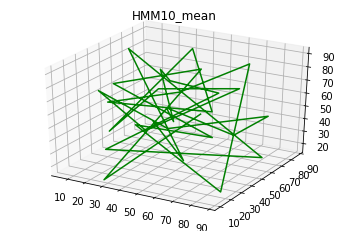

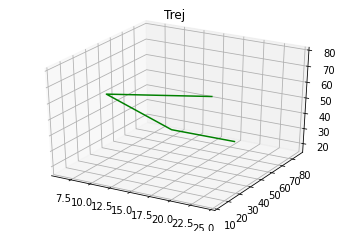

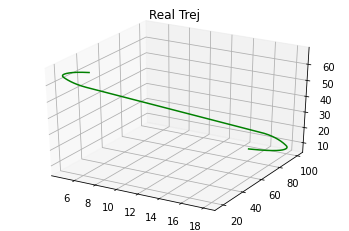

In [57]:
# plot means
plot_trajectory(HMM_diag.means_, 'HMM10_mean')

pred = HMM_diag.predict(org_p_spl[8])
trej = []
for point in pred:
    trej.append(HMM_diag.means_[point])
plot_trajectory(trej, 'Trej')
plot_trajectory(org_p_spl[8], 'Real Trej')

In [9]:
'''
org_states = HMM_10.predict(org_p)
nos_001_states = HMM_10.predict(nos_p_001)
nos_01_states = HMM_10.predict(nos_p_01)
nos_1_states = HMM_10.predict(nos_p_1)
'''

count_001 = 0
count_01 = 0
count_1 = 0

for i in range(len(traj_lens)): # which is 100
    org_states = HMM_10.predict(org_p_spl[i])
    nos_001_states = HMM_10.predict(nos_p_001_spl[i])
    nos_01_states = HMM_10.predict(nos_p_01_spl[i])
    nos_1_states = HMM_10.predict(nos_p_1_spl[i])
    
    for j in range(len(org_states)):
        if org_states[j] != nos_001_states[j]:
            #print(f'{i+1} trajectory: ')
            #print(f'org_states[{j}]: {org_states[j]}')
            #print(f'nos_states[{j}]: {nos_states[j]}')
            #print('\n')
            count_001 += 1
        if org_states[j] != nos_01_states[j]:
            count_01 += 1
        if org_states[j] != nos_1_states[j]:
            count_1 += 1

print('HMM_10 Rate:')
print(f'Noise 0.01:\t{(len(org_p) - count_001)*100/len(org_p)}%')
print(f'Noise 0.1:\t{(len(org_p) - count_01)*100/len(org_p)}%')
print(f'Noise 1:\t{(len(org_p) - count_1)*100/len(org_p)}%')

HMM_10 Rate:
Noise 0.01:	99.52503793626707%
Noise 0.1:	99.5113808801214%
Noise 1:	99.45371775417298%


In [10]:
# try label no. = 20
HMM_20 = hmm.GaussianHMM(n_components=20, covariance_type="full", n_iter=len(traj_lens), verbose=True)
HMM_20.fit(org_p, traj_lens)

         1     -941128.2862             +nan
         2     -873495.9761      +67632.3101
         3     -813066.2750      +60429.7011
         4     -777044.2971      +36021.9779
         5     -741639.0051      +35405.2920
         6     -723071.1551      +18567.8500
         7     -716345.7721       +6725.3829
         8     -714065.6175       +2280.1546
         9     -712782.7904       +1282.8271
        10     -712048.4057        +734.3847
        11     -711536.5485        +511.8572
        12     -711097.5000        +439.0485
        13     -710730.1439        +367.3561
        14     -710389.3655        +340.7784
        15     -710122.2518        +267.1137
        16     -709880.3238        +241.9279
        17     -709733.5814        +146.7424
        18     -709582.8960        +150.6855
        19     -709494.9878         +87.9082
        20     -709435.7958         +59.1920
        21     -709327.8154        +107.9804
        22     -709174.8723        +152.9431
        23

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=20, n_iter=100, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [ ]:
# plot means
plot_trajectory(HMM_20.means_, 'HMM20_mean')
#print(HMM_20.means_)

In [ ]:
pred = HMM_20.predict(org_p_spl[0])
trej = []
for point in pred:
    trej.append(HMM_20.means_[point])
plot_trajectory(trej, 'Trej')
plot_trajectory(org_p_spl[0], 'Real Trej')

In [ ]:
# try label no. = 100
HMM_100 = hmm.GaussianHMM(n_components=100, covariance_type="full", n_iter=len(traj_lens), verbose=True)
HMM_100.fit(org_p, traj_lens)

In [ ]:
# plot means
plot_trajectory(HMM_100.means_, 'HMM100_mean')
#print(HMM_100.means_)

In [ ]:
pred = HMM_100.predict(org_p_spl[78])
trej = []
for point in pred:
    trej.append(HMM_100.means_[point])
plot_trajectory(trej, 'Trej')
plot_trajectory(org_p_spl[78], 'Real Trej')

In [ ]:
# try label no. = 200
HMM_200 = hmm.GaussianHMM(n_components=200, covariance_type="full", n_iter=len(traj_lens), verbose=True)
HMM_200.fit(org_p, traj_lens)